### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.


Notes:
ideally, I want to use time-based cross-validation.
since I have panel data, it is not a trivial task.
need to find some solution online.
e.g., https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8.

for now, will try to do siple for loop.


In [226]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill, optuna, pickle
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [227]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [228]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [229]:
# 1. Import data #

min_prd = 384

time0 = time.time()
#df = pd.read_csv('../input/cpcrsp-46/IMLEAP_v4.csv')
with open('../input/kaggle-46pkl/IMLEAP_v4.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
df = df[df.prd.isin(range(min_prd-1, min_prd+62))]
display(df.shape, df.head(), df.count())

(159567, 46)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
8,10005,383,NaN,-72.706514,1990,-0.64,30.0,0.490174,-0.214332,0.0,-0.230583,-22.380465,-38.380158,NaN,5.732938,5.391287,0.492262,1.4066,5.455535,4.690786,3.473044,NaN,-0.934794,0.750140,-0.084639,0.015282,0.306039,-0.241753,NaN,1.4066,NaN,NaN,21.135115,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,-43.710657,0.765013,0.647098,0.741531,3.367760,3.336121
9,10005,384,NaN,-67.514581,1990,-0.69,30.0,0.490174,-0.214332,0.0,-0.230583,-0.640000,-53.826992,NaN,0.765013,0.647098,0.493277,1.4066,0.866870,3.725968,3.473051,NaN,-0.934794,0.750140,-0.084639,0.015282,0.306039,-0.241753,NaN,1.4066,NaN,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,-43.806772,0.765013,0.647098,0.750895,2.328417,3.336079
10,10005,385,NaN,-62.951924,1990,-0.68,30.0,0.490174,-0.214332,0.0,-0.230583,-0.690000,-44.500763,NaN,0.765013,0.647098,0.538328,1.4066,0.866870,3.725977,3.313428,NaN,-0.934794,0.750140,-0.084639,0.015282,0.306039,-0.424011,NaN,1.4066,NaN,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,-29.825580,3.624354,3.579437,0.776122,1.485171,3.263052
11,10005,386,NaN,-63.021898,1990,-0.63,30.0,0.490174,-0.214332,0.0,-0.230583,-0.680000,-44.444822,NaN,0.765013,0.647098,0.538359,1.4066,0.866870,2.227182,3.313446,NaN,-0.934794,0.750140,-0.084639,0.015282,0.306039,-0.424011,NaN,1.4066,NaN,NaN,1.406600,NaN,NaN,21.135115,NaN,NaN,1.4066,NaN,-33.315908,0.765013,0.647098,0.837432,1.485034,3.167953
12,10005,387,NaN,-71.270748,1990,-0.68,30.0,0.667021,-0.123134,0.0,-0.220930,-0.630000,-44.428036,NaN,0.765013,0.647098,0.539508,1.4066,0.866870,2.227184,3.313454,NaN,-0.934794,0.490174,-0.214332,0.000000,-0.230583,-0.424011,NaN,1.4066,NaN,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,-33.516946,0.765013,0.647098,0.843440,1.485001,3.167929


PERMNO          159567
prd             159567
mom482          137496
mom242          157726
year            159567
RET             159567
ind             159567
bm              159567
op              159567
gp              159567
inv             159474
mom11           159567
mom122          159567
amhd            121257
ivol_capm       159562
ivol_ff5        159562
beta_bw         159567
MAX             159567
vol1m           159552
vol6m           159462
vol12m          159264
BAspr           108565
size            159567
lbm             159567
lop             159567
lgp             159567
linv            159567
llme            159567
l1amhd          121269
l1MAX           159564
l1BAspr         107155
l3amhd          121320
l3MAX           159544
l3BAspr         104235
l6amhd          121323
l6MAX           159524
l6BAspr          99863
l12amhd         121058
l12MAX          159564
l12BAspr         91204
l12mom122       159005
l12ivol_capm    159462
l12ivol_ff5     159462
l12beta_bw 

<AxesSubplot:>

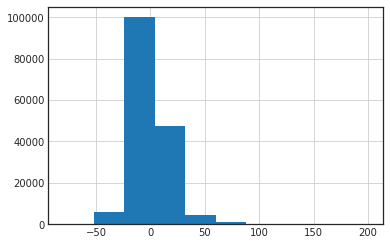

In [230]:
# 2. pEDA #

df.RET.hist()

In [231]:
# explore feature distibution, adjust if seems unreasonable

In [232]:
# add dummies for some missing features

features_miss_dummies = ['amhd', 'BAspr']

for col in features_miss_dummies:
    df[col+'_miss'] = df[col].isnull().astype(int)

df.head()

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
8,10005,383,NaN,-72.706514,1990,-0.64,30.0,0.490174,-0.214332,0.0,-0.230583,-22.380465,-38.380158,NaN,5.732938,5.391287,0.492262,1.4066,5.455535,4.690786,3.473044,NaN,-0.934794,0.750140,-0.084639,0.015282,0.306039,-0.241753,NaN,1.4066,NaN,NaN,21.135115,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,-43.710657,0.765013,0.647098,0.741531,3.367760,3.336121,1,1
9,10005,384,NaN,-67.514581,1990,-0.69,30.0,0.490174,-0.214332,0.0,-0.230583,-0.640000,-53.826992,NaN,0.765013,0.647098,0.493277,1.4066,0.866870,3.725968,3.473051,NaN,-0.934794,0.750140,-0.084639,0.015282,0.306039,-0.241753,NaN,1.4066,NaN,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,-43.806772,0.765013,0.647098,0.750895,2.328417,3.336079,1,1
10,10005,385,NaN,-62.951924,1990,-0.68,30.0,0.490174,-0.214332,0.0,-0.230583,-0.690000,-44.500763,NaN,0.765013,0.647098,0.538328,1.4066,0.866870,3.725977,3.313428,NaN,-0.934794,0.750140,-0.084639,0.015282,0.306039,-0.424011,NaN,1.4066,NaN,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,-29.825580,3.624354,3.579437,0.776122,1.485171,3.263052,1,1
11,10005,386,NaN,-63.021898,1990,-0.63,30.0,0.490174,-0.214332,0.0,-0.230583,-0.680000,-44.444822,NaN,0.765013,0.647098,0.538359,1.4066,0.866870,2.227182,3.313446,NaN,-0.934794,0.750140,-0.084639,0.015282,0.306039,-0.424011,NaN,1.4066,NaN,NaN,1.406600,NaN,NaN,21.135115,NaN,NaN,1.4066,NaN,-33.315908,0.765013,0.647098,0.837432,1.485034,3.167953,1,1
12,10005,387,NaN,-71.270748,1990,-0.68,30.0,0.667021,-0.123134,0.0,-0.220930,-0.630000,-44.428036,NaN,0.765013,0.647098,0.539508,1.4066,0.866870,2.227184,3.313454,NaN,-0.934794,0.490174,-0.214332,0.000000,-0.230583,-0.424011,NaN,1.4066,NaN,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,-33.516946,0.765013,0.647098,0.843440,1.485001,3.167929,1,1


In [233]:
# 3. Train-test split #

temp_cols = ['PERMNO', 'prd', 'year']

train = df[df.prd<(min_prd+60)]
test = df[df.prd==(min_prd+60)]
train.drop(columns=temp_cols, inplace=True)
test.drop(columns=temp_cols, inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

(154591, 45)

(2497, 45)

,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
8,NaN,-72.706514,-0.64,30.0,0.490174,-0.214332,0.0,-0.230583,-22.380465,-38.380158,NaN,5.732938,5.391287,0.492262,1.4066,5.455535,4.690786,3.473044,NaN,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.4066,NaN,NaN,21.135115,NaN,NaN,1.4066,NaN,NaN,1.4066,NaN,-43.710657,0.765013,0.647098,0.741531,3.367760,3.336121,1,1
9,NaN,-67.514581,-0.69,30.0,0.490174,-0.214332,0.0,-0.230583,-0.640000,-53.826992,NaN,0.765013,0.647098,0.493277,1.4066,0.866870,3.725968,3.473051,NaN,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.4066,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.4066,NaN,-43.806772,0.765013,0.647098,0.750895,2.328417,3.336079,1,1
10,NaN,-62.951924,-0.68,30.0,0.490174,-0.214332,0.0,-0.230583,-0.690000,-44.500763,NaN,0.765013,0.647098,0.538328,1.4066,0.866870,3.725977,3.313428,NaN,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.424011,NaN,1.4066,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.4066,NaN,-29.825580,3.624354,3.579437,0.776122,1.485171,3.263052,1,1


,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
308,-71.666115,-50.199564,83.4310,12.0,-1.896125,0.081622,0.510535,-0.101827,-14.3489,-42.430472,3.182400,3.363124,2.941161,0.861234,5.5356,3.228927,3.324761,3.442898,6.250000,3.692401,-1.623669,0.013844,0.291257,0.800300,4.345376,3.097367,4.8570,5.263158,2.778245,7.4790,4.651163,2.800786,6.6497,2.040816,2.673470,4.8570,1.538462,-18.575370,3.142974,2.825022,1.048256,3.929775,3.548225,0,0
345,102.462626,170.270066,22.5689,34.0,-1.862198,0.132619,0.757579,0.335288,6.1438,50.020912,2.295714,6.735740,6.005222,0.647692,11.8848,7.065670,4.022678,3.439909,2.564103,4.395057,-1.567054,0.019597,0.839508,-0.112930,3.808339,2.492715,3.4878,0.934579,3.248493,7.5420,1.538462,3.981594,5.2462,2.380952,4.731040,3.4878,4.081633,81.804988,2.942629,2.429158,0.503468,3.131319,3.703239,0,0
577,-47.308239,-54.110858,-4.6067,21.0,0.177905,-0.082748,0.119668,-0.103007,7.0027,-16.399859,2.401087,2.019339,1.878105,1.023677,4.5954,2.036277,3.990957,3.484678,2.666667,4.811550,0.670110,0.063815,0.291788,0.003223,4.881979,2.403057,11.2693,3.076923,2.239765,10.7633,5.769231,1.872630,2.7999,2.816901,2.423493,11.2693,1.333333,-53.126659,6.610402,5.952957,0.353690,4.399474,3.494552,0,0


In [234]:
# 4. Missing values #

col_ignore = ['RET']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]

for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)
    
display(train.count())

mom482          154591
mom242          154591
RET             154591
ind             154591
bm              154591
op              154591
gp              154591
inv             154591
mom11           154591
mom122          154591
amhd            154591
ivol_capm       154591
ivol_ff5        154591
beta_bw         154591
MAX             154591
vol1m           154591
vol6m           154591
vol12m          154591
BAspr           154591
size            154591
lbm             154591
lop             154591
lgp             154591
linv            154591
llme            154591
l1amhd          154591
l1MAX           154591
l1BAspr         154591
l3amhd          154591
l3MAX           154591
l3BAspr         154591
l6amhd          154591
l6MAX           154591
l6BAspr         154591
l12amhd         154591
l12MAX          154591
l12BAspr        154591
l12mom122       154591
l12ivol_capm    154591
l12ivol_ff5     154591
l12beta_bw      154591
l12vol6m        154591
l12vol12m       154591
amhd_miss  

In [235]:
# [optional] Target Encoding


In [236]:
X_train = train.copy()
y_train = X_train.pop('RET')

X_test = test.copy()
y_test = X_test.pop('RET')

In [237]:
# 5. Feature engineering #

time1 = time.time()

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat),
    ('num', StandardScaler(), col_num)])

print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transformation: ', X_train.shape)



Number of features before transformation:  (154591, 44)
time to do feature proprocessing:  0.3267397880554199
Number of features after transformation:  (154591, 92)


In [238]:
# 6. Model fitting #

# first, some trivial baselines:
print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

time1 = time.time()
xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=6, eta=0.05, colsample_bytree=0.6)
xgb1.fit(X_train, y_train)
print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)), time.time()-time1)

mae of a constant model 10.890287712726742
R2 of a constant model 0.0
XGB train: 10.39120989936875 0.1579073139409377 4.229769468307495


In [239]:
time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[300, 500], 'max_depth':[2,3,4], 'eta':[0.015, 0.3, 0.05],
             'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='neg_mean_absolute_error')
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
# this runs for 40 min and finds 
# 'eta': 0.02, 'max_depth': 6, 'n_estimators': 500, 0.01095415380877135
print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, eta=0.015, max_depth=2, n_estimators=300, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.6, eta=0.015, max_depth=2, n_estimators=300, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, eta=0.015, max_depth=2, n_estimators=500, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, eta=0.015, max_depth=2, n_estimators=500, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=0.6, eta=0.015, max_depth=3, n_estimators=300, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.6, eta=0.015, max_depth=3, n_estimators=300, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.6, eta=0.015, max_depth=3, n_estimators=500, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, eta=0.015, max_depth=3, n_estimators=500, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, eta=0.015, max_depth=4, n_estimators=300, subsample=

In [240]:
# time1 = time.time()

# def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

#     cv_regularizer=0.01
#     # Usually values between 0.1 and 0.2 work fine.

#     params = {
#         "tree_method": 'gpu_hist',
#         "verbosity": 0,  # 0 (silent) - 3 (debug)
#         "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "max_depth": trial.suggest_int("max_depth", 2, 10),
#         "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.2),
#         "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
#         "alpha": trial.suggest_loguniform("alpha", 0.1, 20.0),
#         "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
#         "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
#         "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10)    }
#     # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
#     # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
#     # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

#     temp_out = []

#     for i in range(cv_runs):

#         X = X_train
#         y = y_train

#         model = XGBRegressor(**params, njobs=-1)
#         rkf = KFold(n_splits=n_splits, shuffle=True)
#         X_values = X.values
#         y_values = y.values
#         y_pred = np.zeros_like(y_values)
#         y_pred_train = np.zeros_like(y_values)
#         for train_index, test_index in rkf.split(X_values):
#             X_A, X_B = X_values[train_index, :], X_values[test_index, :]
#             y_A, y_B = y_values[train_index], y_values[test_index]
#             model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
#             y_pred[test_index] += model.predict(X_B)
                      
            
#         #score_train = roc_auc_score(y_train, y_pred_train)
#         score_test = mean_absolute_error(y_train, y_pred) 
#         #overfit = score_train-score_test
#         #temp_out.append(score_test-cv_regularizer*overfit)
#         temp_out.append(score_test)

#     return (np.mean(temp_out))

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=30)

# print('Total time for hypermarameter optimization ', time.time()-time1)
# hp = study.best_params
# for key, value in hp.items():
#     print(f"{key:>20s} : {value}")
# print(f"{'best objective value':>20s} : {study.best_value}")

# optuna_hyperpars = study.best_params
# optuna_hyperpars['tree_method']='gpu_hist'

# optuna_xgb = XGBRegressor(**optuna_hyperpars)
# optuna_xgb.fit(X_train, y_train)
# print('Optuna XGB train:', 
#       mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

In [241]:
# Evaluate performance of XGB models:

print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_score(y_test, xgbm.predict(X_test)))
#print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

XGB test: 9.431713072469499 0.0035976181956411946
XGB GS test: 9.371976466451265 0.00966110890471683


In [242]:
print('Total time for a script: ', time.time()-time0)

Total time for a script:  55.89503788948059


In [243]:
# test_size = 0.1
# df.reset_index(inplace=True, drop=True)
# #random.seed(2)
# test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
# train = df.iloc[list(set(df.index)-set(test_index))]
# test = df.iloc[test_index]
# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)
# display(train.shape, test.shape, train.head(3), test.head(3))